In [1]:
# PySpark and others
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, stddev, mean, lit, lead, min as spark_min, max as spark_max
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import Window
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Stock Data Analysis") \
    .getOrCreate()

In [3]:
all_df = spark.read.csv("nasdaq100.csv", header=True, inferSchema=True)

In [4]:
all_df.show(5)

+------+----------+-------+-------+-------+-------+
|ticker|      date|   open|   high|    low|  close|
+------+----------+-------+-------+-------+-------+
|  CSCO|2011-01-03|14.5212| 14.644|14.4741|14.5516|
|  CSCO|2011-01-04|14.6116|14.6282|14.4868|14.5722|
|  CSCO|2011-01-05|14.6116|14.8089|14.5782| 14.751|
|  CSCO|2011-01-06|14.8423|14.8806|14.7422|14.8737|
|  CSCO|2011-01-07|14.8089| 14.913|14.7932|14.8904|
+------+----------+-------+-------+-------+-------+
only showing top 5 rows



In [5]:
# Check distinct tickers
all_df.select("ticker").distinct().show()
all_df.groupBy("ticker").count().show()

+------+
|ticker|
+------+
|  CSCO|
|  MCHP|
|   ADI|
|  GILD|
|  MNST|
|  INTC|
|   MDB|
|  INTU|
|  CCEP|
|  VRTX|
|   PDD|
|  GEHC|
|  COST|
|  ISRG|
|  ABNB|
|   WBD|
|  MSTR|
|   GFS|
|   KDP|
|  WDAY|
+------+
only showing top 20 rows

+------+-----+
|ticker|count|
+------+-----+
|  CSCO| 3570|
|  MCHP| 3570|
|   ADI| 3570|
|  GILD| 3570|
|  MNST| 3570|
|  INTC| 3570|
|   MDB| 1859|
|  INTU| 3570|
|  CCEP| 3570|
|  VRTX| 3570|
|   PDD| 1667|
|  GEHC|  561|
|  COST| 3570|
|  ISRG| 3570|
|  ABNB| 1068|
|   WBD| 3570|
|  MSTR| 3570|
|   GFS|  846|
|   KDP| 3570|
|  WDAY| 3121|
+------+-----+
only showing top 20 rows



In [6]:
# Disruption Periods Filtering
stable_period = all_df.filter((col("date") >= "2017-01-01") & (col("date") <= "2017-12-31"))
trade_war_period = all_df.filter((col("date") >= "2018-01-01") & (col("date") <= "2019-12-31"))
covid_period = all_df.filter((col("date") >= "2020-02-01") & (col("date") <= "2020-08-31"))
ukraine_period = all_df.filter((col("date") >= "2022-02-01") & (col("date") <= "2022-12-31"))

# Training set (before 2017)
train_period = all_df.filter((col("date") >= "2011-01-01") & (col("date") <= "2016-12-31"))


In [7]:
pandas_df = train_period.toPandas()
print(f"Training set shape: {pandas_df.shape}")

pandas_df = stable_period.toPandas()
print(f"Test set shape: {pandas_df.shape}")

Training set shape: (124166, 6)
Test set shape: (21887, 6)


In [ ]:
"""
train_period.select("close").describe().show()
train_period.select("open").describe().show()
train_period.select("high").describe().show()
train_period.select("low").describe().show()
"""

In [8]:
# Substep 7:

# Cache the disruption period DataFrames
stable_period.cache()
trade_war_period.cache()
covid_period.cache()
ukraine_period.cache()

# Cache the train period for each disruption
train_period.cache()

# Force caching by doing a small action like counting
stable_period.count()
trade_war_period.count()
covid_period.count()
ukraine_period.count()
train_period.count()

124166

In [9]:
# ????
# Substep 8.5 : Check for missing values

from pyspark.sql.functions import sum

# Check missing values for each column in the combined dataset
all_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in all_df.columns]).show()

+------+----+----+----+---+-----+
|ticker|date|open|high|low|close|
+------+----+----+----+---+-----+
|     0|   0|   0|   0|  0|    0|
+------+----+----+----+---+-----+



In [10]:
# ????
# Substep 8.6:

# For stable period
print("Missing values in stable period:")
stable_period.select([sum(col(c).isNull().cast("int")).alias(c) for c in stable_period.columns]).show()

# For US-China Trade War period
print("Missing values in US-China Trade War testing period:")
trade_war_period.select([sum(col(c).isNull().cast("int")).alias(c) for c in trade_war_period.columns]).show()

# For COVID-19 period
print("Missing values in COVID-19 testing period:")
covid_period.select([sum(col(c).isNull().cast("int")).alias(c) for c in covid_period.columns]).show()

# For Russia-Ukraine Conflict period
print("Missing values in Russia-Ukraine Conflict testing period:")
ukraine_period.select([sum(col(c).isNull().cast("int")).alias(c) for c in ukraine_period.columns]).show()

# For train period
print("Missing values in stable period:")
train_period.select([sum(col(c).isNull().cast("int")).alias(c) for c in train_period.columns]).show()


Missing values in stable period:
+------+----+----+----+---+-----+
|ticker|date|open|high|low|close|
+------+----+----+----+---+-----+
|     0|   0|   0|   0|  0|    0|
+------+----+----+----+---+-----+

Missing values in US-China Trade War testing period:
+------+----+----+----+---+-----+
|ticker|date|open|high|low|close|
+------+----+----+----+---+-----+
|     0|   0|   0|   0|  0|    0|
+------+----+----+----+---+-----+

Missing values in COVID-19 testing period:
+------+----+----+----+---+-----+
|ticker|date|open|high|low|close|
+------+----+----+----+---+-----+
|     0|   0|   0|   0|  0|    0|
+------+----+----+----+---+-----+

Missing values in Russia-Ukraine Conflict testing period:
+------+----+----+----+---+-----+
|ticker|date|open|high|low|close|
+------+----+----+----+---+-----+
|     0|   0|   0|   0|  0|    0|
+------+----+----+----+---+-----+

Missing values in stable period:
+------+----+----+----+---+-----+
|ticker|date|open|high|low|close|
+------+----+----+----+---+-

In [11]:
# Alternative Substep 9-12.5 consider all up/down movement 

from pyspark.sql.window import Window
from pyspark.sql.functions import avg, stddev, lag, lead, when

# Common window specifications
window_spec_5 = Window.partitionBy("ticker").orderBy("date").rowsBetween(-4, 0)
window_spec_10 = Window.partitionBy("ticker").orderBy("date").rowsBetween(-9, 0)
window_spec_lag = Window.partitionBy("ticker").orderBy("date")
window_spec_lead = Window.partitionBy("ticker").orderBy("date")

# Function to add all features
def add_features(df):
    return df \
        .withColumn("ma_5", avg("close").over(window_spec_5)) \
        .withColumn("ma_10", avg("close").over(window_spec_10)) \
        .withColumn("volatility_5", stddev("close").over(window_spec_5)) \
        .withColumn("volatility_10", stddev("close").over(window_spec_10)) \
        .withColumn("close_lag1", lag("close", 1).over(window_spec_lag)) \
        .withColumn("open_lag1", lag("open", 1).over(window_spec_lag)) \
        .withColumn("high_lag1", lag("high", 1).over(window_spec_lag)) \
        .withColumn("low_lag1", lag("low", 1).over(window_spec_lag)) \
        .withColumn("return_open_close", (col("close") - col("open")) / col("open")) \
        .withColumn("return_high_low", (col("high") - col("low")) / col("open")) \
        .withColumn("return_close_lag1", (col("close") - col("close_lag1")) / col("close_lag1")) \
        .withColumn("close_lead1", lead("close", 1).over(window_spec_lead)) \
        .withColumn("label_class", when(col("close_lead1") > col("close"), 1).otherwise(0)) \
        .withColumn("label_regress", (col("close_lead1") - col("close")) / col("close"))

# Apply to training set
train_period = add_features(train_period)

# Apply to each testing set
stable_period = add_features(stable_period)
trade_war_period = add_features(trade_war_period)
covid_period = add_features(covid_period)   
ukraine_period = add_features(ukraine_period)   



In [12]:
#  Substep 13: 

feature_columns = [
    "open", "high", "low", "close",
    "ma_5", "ma_10", "volatility_5", "volatility_10",
    "close_lag1", "open_lag1", "high_lag1", "low_lag1",
    "return_open_close", "return_high_low", "return_close_lag1"
]

# For classification task
classification_columns = feature_columns + ["label_class"]

# For regression task
regression_columns = feature_columns + ["label_regress"]

# For classification, select only these columns for the training period and disruptions periods
train_period_class = train_period.select(classification_columns)
stable_period_class = stable_period.select(classification_columns)
trade_war_period_class = trade_war_period.select(classification_columns)
covid_period_class = covid_period.select(classification_columns)
ukraine_period_class = ukraine_period.select(classification_columns)

# For regression, select only these columns for the training period and disruptions periods
train_period_regress = train_period.select(regression_columns)
stable_period_regress = stable_period.select(regression_columns)
trade_war_period_regress = trade_war_period.select(regression_columns)
covid_period_regress = covid_period.select(regression_columns)
ukraine_period_regress = ukraine_period.select(regression_columns)

In [13]:
# Substep 14: 

from pyspark.ml.feature import VectorAssembler

# Define assembler
assembler = VectorAssembler(
    inputCols=feature_columns,
    handleInvalid="skip",
    outputCol="features"
)

# Apply the assembler to training dataset for classification
train_period_class = assembler.transform(train_period_class)

# Apply the assembler for test datasets for classification
stable_period_class = assembler.transform(stable_period_class)
trade_war_period_class = assembler.transform(trade_war_period_class)
covid_period_class = assembler.transform(covid_period_class)
ukraine_period_class = assembler.transform(ukraine_period_class)


# Apply the assembler for regression datasets
train_period_regress = assembler.transform(train_period_regress)

# Apply the assembler for regression datasets
stable_period_regress = assembler.transform(stable_period_regress)
trade_war_period_regress = assembler.transform(trade_war_period_regress)
covid_period_regress = assembler.transform(covid_period_regress)
ukraine_period_regress = assembler.transform(ukraine_period_regress)

### Scaling

In [14]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(train_period_class)

train_period_class_scaled = scaler_model.transform(train_period_class)
stable_period_class_scaled = scaler_model.transform(stable_period_class)
trade_war_period_class_scaled = scaler_model.transform(trade_war_period_class)
covid_period_class_scaled = scaler_model.transform(covid_period_class)
ukraine_period_class_scaled = scaler_model.transform(ukraine_period_class)

train_period_regress_scaled = scaler_model.transform(train_period_regress)
stable_period_regress_scaled = scaler_model.transform(stable_period_regress)
trade_war_period_regress_scaled = scaler_model.transform(trade_war_period_regress)
covid_period_regress_scaled = scaler_model.transform(covid_period_regress)
ukraine_period_regress_scaled = scaler_model.transform(ukraine_period_regress)





In [ ]:
"""
train_period_class_scaled.groupBy("direction").count().orderBy("direction").show()
stable_period_class_scaled.groupBy("direction").count().orderBy("direction").show()
trade_war_period_class_scaled.groupBy("direction").count().orderBy("direction").show()
covid_period_class_scaled.groupBy("direction").count().orderBy("direction").show()
ukraine_period_class_scaled.groupBy("direction").count().orderBy("direction").show()
"""

### Linear Regression (SCALED)

In [ ]:
# test - show rows with  missing vlues
#stable_period_regress_scaled.filter(~col("label_regress").cast("double").isNotNull()).show()

In [15]:
# remove rows with missing values

# for scaled dataset
train_period_regress_scaled = train_period_regress_scaled.filter(col("label_regress").cast("double").isNotNull())
stable_period_regress_scaled = stable_period_regress_scaled.filter(col("label_regress").cast("double").isNotNull())
trade_war_period_regress_scaled = trade_war_period_regress_scaled.filter(col("label_regress").cast("double").isNotNull())
covid_period_regress_scaled = covid_period_regress_scaled.filter(col("label_regress").cast("double").isNotNull())
ukraine_period_regress_scaled = ukraine_period_regress_scaled.filter(col("label_regress").cast("double").isNotNull())

# for unscaled dataset
# remove rows with missing values
train_period_regress = train_period_regress.filter(col("label_regress").cast("double").isNotNull())
stable_period_regress = stable_period_regress.filter(col("label_regress").cast("double").isNotNull())
trade_war_period_regress = trade_war_period_regress.filter(col("label_regress").cast("double").isNotNull())
covid_period_regress = covid_period_regress.filter(col("label_regress").cast("double").isNotNull())
ukraine_period_regress = ukraine_period_regress.filter(col("label_regress").cast("double").isNotNull())

In [16]:
# Linear Regression
lr = LinearRegression(featuresCol="scaled_features", labelCol="label_regress")
lr_model = lr.fit(train_period_regress_scaled)

In [17]:
# Regression evaluation
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
predictions_train = lr_model.transform(train_period_regress_scaled)
predictions_train.select("label_regress", "prediction").show(5)
train_rmse = reg_eval.evaluate(predictions_train)
train_r2 = reg_eval.setMetricName("r2").evaluate(predictions_train)
print(f"Train period RMSE: {train_rmse}")
print(f"Train period R2: {train_r2}")

# Stable period evaluation
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
predictions_stable = lr_model.transform(stable_period_regress_scaled)
predictions_stable.select("label_regress", "prediction").show(5)
test_rmse = reg_eval.evaluate(predictions_stable)
reg_eval.setMetricName("r2")
test_r2 = reg_eval.evaluate(predictions_stable)
print(f"Stable period RMSE: {test_rmse}")
print(f"Stable period R2: {test_r2}")

# Evaluate on disruption periods
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
predictions_trade_war = lr_model.transform(trade_war_period_regress_scaled)
predictions_trade_war.select("label_regress", "prediction").show(5)
trade_war_rmse = reg_eval.evaluate(predictions_trade_war)
trade_war_r2 = reg_eval.setMetricName("r2").evaluate(predictions_trade_war)
print(f"Trade War period RMSE: {trade_war_rmse}")
print(f"Trade War period R2: {trade_war_r2}")

reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
predictions_covid = lr_model.transform(covid_period_regress_scaled)
predictions_covid.select("label_regress", "prediction").show(5)
covid_rmse = reg_eval.evaluate(predictions_covid)
covid_r2 = reg_eval.setMetricName("r2").evaluate(predictions_covid)
print(f"COVID period RMSE: {covid_rmse}")
print(f"COVID period R2: {covid_r2}")

reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
predictions_ukraine = lr_model.transform(ukraine_period_regress_scaled)
predictions_ukraine.select("label_regress", "prediction").show(5)
ukraine_rmse = reg_eval.evaluate(predictions_ukraine)
ukraine_r2 = reg_eval.setMetricName("r2").evaluate(predictions_ukraine)
print(f"Ukraine period RMSE: {ukraine_rmse}")
print(f"Ukraine period R2: {ukraine_r2}")

+--------------------+--------------------+
|       label_regress|          prediction|
+--------------------+--------------------+
|0.008299207757825779|1.010586399041692...|
|-7.86704690726806...|0.001042658259896...|
|0.007164649148705921|5.685153654969837E-4|
|0.018702730168656784|6.293174033395084E-4|
|-0.00230211410812...| 4.99860612965166E-7|
+--------------------+--------------------+
only showing top 5 rows

Train period RMSE: 0.030711238257194497
Train period R2: 0.00678785930188841
+--------------------+--------------------+
|       label_regress|          prediction|
+--------------------+--------------------+
|0.005175678363822...|9.594421103119289E-4|
|0.010961384117537089|7.493267656883297E-4|
|0.009146009903646142|5.636851738053296E-4|
|0.001074067554897...|6.800518117484162E-4|
|0.005364575857614459|8.798913140454622E-4|
+--------------------+--------------------+
only showing top 5 rows

Stable period RMSE: 0.016305635365069977
Stable period R2: -0.003796823640024538


### Logistic Regression (SCALED)

In [18]:
# Logistic Regression (Classification: price up/down)
logr = LogisticRegression(featuresCol="scaled_features", labelCol="label_class")
logr_model = logr.fit(train_period_class_scaled)

In [19]:
# Classification evaluation
cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
predictions_train = logr_model.transform(train_period_class_scaled)
predictions_train.select("label_class", "prediction", "probability").show(5)
train_accuracy = cls_eval.evaluate(predictions_train)
train_f1 = cls_eval.setMetricName("f1").evaluate(predictions_train)
print(f"Train period Accuracy: {train_accuracy:.4f}")
print(f"Train period F1 Score: {train_f1:.4f}")

# Stable period evaluation
cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
predictions_stable = logr_model.transform(stable_period_class_scaled)
predictions_stable.select("label_class", "prediction", "probability").show(5)
stable_accuracy = cls_eval.evaluate(predictions_stable)
stable_f1 = cls_eval.setMetricName("f1").evaluate(predictions_stable)
print(f"Stable period Accuracy: {stable_accuracy:.4f}")
print(f"Stable period F1 Score: {stable_f1:.4f}")

# Evaluate on disruption periods
cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
predictions_trade_war = logr_model.transform(trade_war_period_class_scaled)
predictions_trade_war.select("label_class", "prediction", "probability").show(5)
trade_war_accuracy = cls_eval.evaluate(predictions_trade_war)
trade_war_f1 = cls_eval.setMetricName("f1").evaluate(predictions_trade_war)
print(f"Trade War period Accuracy: {trade_war_accuracy:.4f}")
print(f"Trade War period F1 Score: {trade_war_f1:.4f}")

cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
predictions_covid = logr_model.transform(covid_period_class_scaled)
predictions_covid.select("label_class", "prediction", "probability").show(5)
covid_accuracy = cls_eval.evaluate(predictions_covid)
covid_f1 = cls_eval.setMetricName("f1").evaluate(predictions_covid)
print(f"COVID period Accuracy: {covid_accuracy:.4f}")
print(f"COVID period F1 Score: {covid_f1:.4f}")

cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
predictions_ukraine = logr_model.transform(ukraine_period_class_scaled)
predictions_ukraine.select("label_class", "prediction", "probability").show(5)
ukraine_accuracy = cls_eval.evaluate(predictions_ukraine)
ukraine_f1 = cls_eval.setMetricName("f1").evaluate(predictions_ukraine)
print(f"Ukraine period Accuracy: {ukraine_accuracy:.4f}")
print(f"Ukraine period F1 Score: {ukraine_f1:.4f}")

+-----------+----------+--------------------+
|label_class|prediction|         probability|
+-----------+----------+--------------------+
|          1|       1.0|[0.47939231366643...|
|          0|       1.0|[0.48989482280970...|
|          1|       1.0|[0.47859657797948...|
|          1|       1.0|[0.48592292601277...|
|          0|       1.0|[0.48943832591800...|
+-----------+----------+--------------------+
only showing top 5 rows

Train period Accuracy: 0.5180
Train period F1 Score: 0.4018
+-----------+----------+--------------------+
|label_class|prediction|         probability|
+-----------+----------+--------------------+
|          1|       1.0|[0.48227821906984...|
|          1|       1.0|[0.48599806102619...|
|          1|       1.0|[0.48873591464088...|
|          1|       1.0|[0.48794807122813...|
|          1|       1.0|[0.48418757608658...|
+-----------+----------+--------------------+
only showing top 5 rows

Stable period Accuracy: 0.5388
Stable period F1 Score: 0.4142


### Confusion Matrix for Logistic Regression (SCALED)

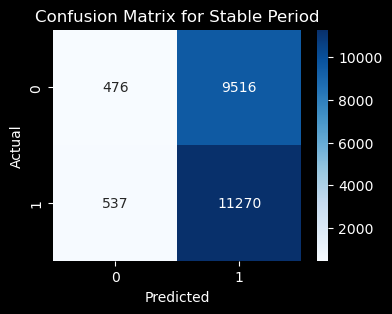

In [20]:
# Select label and prediction
preds_df = predictions_stable.select("label_class", "prediction")
preds_pd = preds_df.toPandas()

# Get y_true and y_pred
y_true = preds_pd['label_class']
y_pred = preds_pd['prediction']

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Stable Period')
plt.show()

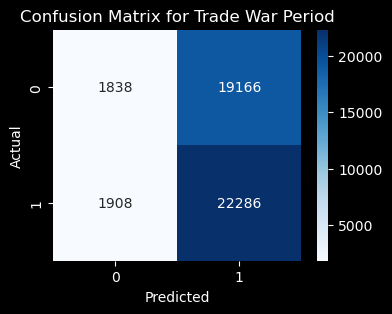

In [21]:
 # Select label and prediction
preds_df = predictions_trade_war.select("label_class", "prediction")
preds_pd = preds_df.toPandas()

# Get y_true and y_pred
y_true = preds_pd['label_class']
y_pred = preds_pd['prediction']

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Trade War Period')
plt.show()

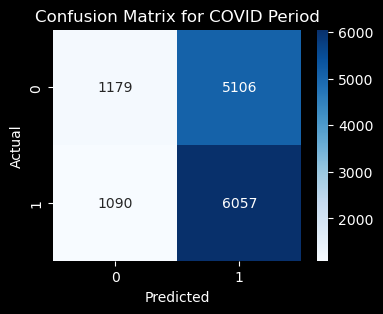

In [22]:
 # Select label and prediction
preds_df = predictions_covid.select("label_class", "prediction")
preds_pd = preds_df.toPandas()

# Get y_true and y_pred
y_true = preds_pd['label_class']
y_pred = preds_pd['prediction']

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for COVID Period')
plt.show()

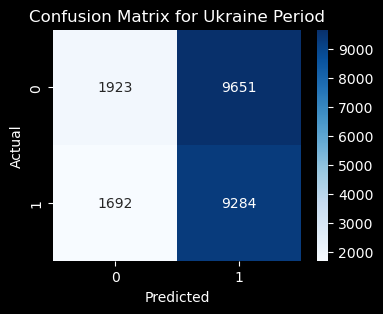

In [23]:
 # Select label and prediction
preds_df = predictions_ukraine.select("label_class", "prediction")
preds_pd = preds_df.toPandas()

# Get y_true and y_pred
y_true = preds_pd['label_class']
y_pred = preds_pd['prediction']

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Ukraine Period')
plt.show()

## Classification in 4 Ways

### SCALED

In [25]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier

classifiers = {
    "LogisticRegression": LogisticRegression(featuresCol="scaled_features", labelCol="label_class"),
    "RandomForestClassifier": RandomForestClassifier(featuresCol="scaled_features", labelCol="label_class"),
    "GBTClassifier": GBTClassifier(featuresCol="scaled_features", labelCol="label_class"),
    "DecisionTreeClassifier": DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label_class"),
}

for name, model in classifiers.items():
    print(f"\nTraining {name}...")
    clf_model = model.fit(train_period_class_scaled)

    # Evaluate on training set
    preds = clf_model.transform(train_period_class_scaled)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    train_accuracy = cls_eval.evaluate(preds)
    train_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Train period Accuracy: {train_accuracy:.4f}")
    print(f"Train period F1 Score: {train_f1:.4f}")


    # Evaluate on stable period
    preds = clf_model.transform(stable_period_class_scaled)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    stable_accuracy = cls_eval.evaluate(preds)
    stable_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Stable period Accuracy: {stable_accuracy:.4f}")
    print(f"Stable period F1 Score: {stable_f1:.4f}")

    # Evaluate on trade war period
    preds = clf_model.transform(trade_war_period_class_scaled)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    trade_war_accuracy = cls_eval.evaluate(preds)
    trade_war_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Trade War period Accuracy: {trade_war_accuracy:.4f}")
    print(f"Trade War period F1 Score: {trade_war_f1:.4f}")

    # Evaluate on COVID period
    preds = clf_model.transform(covid_period_class_scaled)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    covid_accuracy = cls_eval.evaluate(preds)
    covid_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"COVID period Accuracy: {covid_accuracy:.4f}")
    print(f"COVID period F1 Score: {covid_f1:.4f}")

    # Evaluate on Ukraine period
    preds = clf_model.transform(ukraine_period_class_scaled)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    ukraine_accuracy = cls_eval.evaluate(preds)
    ukraine_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Ukraine period Accuracy: {ukraine_accuracy:.4f}")
    print(f"Ukraine period F1 Score: {ukraine_f1:.4f}")





Training LogisticRegression...
Train period Accuracy: 0.5180
Train period F1 Score: 0.4018
Stable period Accuracy: 0.5388
Stable period F1 Score: 0.4142
Trade War period Accuracy: 0.5337
Trade War period F1 Score: 0.4325
COVID period Accuracy: 0.5387
COVID period F1 Score: 0.4810
Ukraine period Accuracy: 0.4969
Ukraine period F1 Score: 0.4320

Training RandomForestClassifier...
Train period Accuracy: 0.5261
Train period F1 Score: 0.4587
Stable period Accuracy: 0.5336
Stable period F1 Score: 0.4921
Trade War period Accuracy: 0.5224
Trade War period F1 Score: 0.4916
COVID period Accuracy: 0.5421
COVID period F1 Score: 0.5203
Ukraine period Accuracy: 0.4898
Ukraine period F1 Score: 0.4649

Training GBTClassifier...
Train period Accuracy: 0.5405
Train period F1 Score: 0.5140
Stable period Accuracy: 0.5244
Stable period F1 Score: 0.5069
Trade War period Accuracy: 0.5145
Trade War period F1 Score: 0.4980
COVID period Accuracy: 0.5230
COVID period F1 Score: 0.5138
Ukraine period Accuracy: 0.

### NON-SCALED

In [26]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier

classifiers = {
    "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label_class"),
    "RandomForestClassifier": RandomForestClassifier(featuresCol="features", labelCol="label_class"),
    "GBTClassifier": GBTClassifier(featuresCol="features", labelCol="label_class"),
    "DecisionTreeClassifier": DecisionTreeClassifier(featuresCol="features", labelCol="label_class"),
}

for name, model in classifiers.items():
    print(f"\nTraining {name}...")
    clf_model = model.fit(train_period_class)

    # Evaluate on training set
    preds = clf_model.transform(train_period_class)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    train_accuracy = cls_eval.evaluate(preds)
    train_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Train period Accuracy: {train_accuracy:.4f}")
    print(f"Train period F1 Score: {train_f1:.4f}")
    

    # Evaluate on stable period
    preds = clf_model.transform(stable_period_class)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    stable_accuracy = cls_eval.evaluate(preds)
    stable_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Stable period Accuracy: {stable_accuracy:.4f}")
    print(f"Stable period F1 Score: {stable_f1:.4f}")

    # Evaluate on trade war period
    preds = clf_model.transform(trade_war_period_class)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    trade_war_accuracy = cls_eval.evaluate(preds)
    trade_war_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Trade War period Accuracy: {trade_war_accuracy:.4f}")
    print(f"Trade War period F1 Score: {trade_war_f1:.4f}")

    # Evaluate on COVID period
    preds = clf_model.transform(covid_period_class)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    covid_accuracy = cls_eval.evaluate(preds)
    covid_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"COVID period Accuracy: {covid_accuracy:.4f}")
    print(f"COVID period F1 Score: {covid_f1:.4f}")

    # Evaluate on Ukraine period
    preds = clf_model.transform(ukraine_period_class)
    #preds.select("label_class", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_class", metricName="accuracy")
    ukraine_accuracy = cls_eval.evaluate(preds)
    ukraine_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Ukraine period Accuracy: {ukraine_accuracy:.4f}")
    print(f"Ukraine period F1 Score: {ukraine_f1:.4f}")





Training LogisticRegression...
Train period Accuracy: 0.5179
Train period F1 Score: 0.4017
Stable period Accuracy: 0.5388
Stable period F1 Score: 0.4143
Trade War period Accuracy: 0.5337
Trade War period F1 Score: 0.4326
COVID period Accuracy: 0.5392
COVID period F1 Score: 0.4819
Ukraine period Accuracy: 0.4969
Ukraine period F1 Score: 0.4324

Training RandomForestClassifier...
Train period Accuracy: 0.5273
Train period F1 Score: 0.4527
Stable period Accuracy: 0.5336
Stable period F1 Score: 0.4822
Trade War period Accuracy: 0.5239
Trade War period F1 Score: 0.4809
COVID period Accuracy: 0.5500
COVID period F1 Score: 0.5198
Ukraine period Accuracy: 0.4875
Ukraine period F1 Score: 0.4423

Training GBTClassifier...
Train period Accuracy: 0.5403
Train period F1 Score: 0.5072
Stable period Accuracy: 0.5288
Stable period F1 Score: 0.5008
Trade War period Accuracy: 0.5238
Trade War period F1 Score: 0.4971
COVID period Accuracy: 0.5222
COVID period F1 Score: 0.5083
Ukraine period Accuracy: 0.

## Regression in 4 Ways

### SCALED

In [27]:
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor, DecisionTreeRegressor

regressors = {
    "LinearRegression": LinearRegression(featuresCol="scaled_features", labelCol="label_regress"),
    "GBTRegressor": GBTRegressor(featuresCol="scaled_features", labelCol="label_regress"),
    "RandomForestRegressor": RandomForestRegressor(featuresCol="scaled_features", labelCol="label_regress"),
    "DecisionTreeRegressor": DecisionTreeRegressor(featuresCol="scaled_features", labelCol="label_regress")
}

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    reg_model = model.fit(train_period_regress_scaled)

    # Evaluate on training set
    preds = reg_model.transform(train_period_regress_scaled)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    train_rmse = reg_eval.evaluate(preds)
    reg_eval.setMetricName("r2")
    train_r2 = reg_eval.evaluate(preds)
    print(f"Train period RMSE: {train_rmse}")
    print(f"Train period R2: {train_r2}")

    # Evaluate on stable period
    preds = reg_model.transform(stable_period_regress_scaled)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    stable_rmse = reg_eval.evaluate(preds)
    stable_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"Stable period RMSE: {stable_rmse}")
    print(f"Stable period R2: {stable_r2}")

    # Evaluate on trade war period
    preds = reg_model.transform(trade_war_period_regress_scaled)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    trade_war_rmse = reg_eval.evaluate(preds)
    trade_war_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"Trade War period RMSE: {test_rmse}")
    print(f"Trade War period R2: {test_r2}")

    # Evaluate on COVID period
    preds = reg_model.transform(covid_period_regress_scaled)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    covid_rmse = reg_eval.evaluate(preds)
    covid_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"COVID period RMSE: {test_rmse}")
    print(f"COVID period R2: {test_r2}")

    # Evaluate on Ukraine period
    preds = reg_model.transform(ukraine_period_regress_scaled)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    ukraine_rmse = reg_eval.evaluate(preds)
    ukraine_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"Ukraine period RMSE: {ukraine_rmse}")
    print(f"Ukraine period R2: {ukraine_r2}")
    





Training LinearRegression...
Train period RMSE: 0.030711238257194497
Train period R2: 0.00678785930188841
Stable period RMSE: 0.016305635365069977
Stable period R2: -0.003796823640024538
Trade War period RMSE: 0.016305635365069977
Trade War period R2: -0.003796823640024538
COVID period RMSE: 0.016305635365069977
COVID period R2: -0.003796823640024538
Ukraine period RMSE: 0.03149410225567793
Ukraine period R2: -0.003026647703651353

Training GBTRegressor...
Train period RMSE: 0.02524134430278274
Train period R2: 0.3290775461430271
Stable period RMSE: 0.016699993430347667
Stable period R2: -0.052938402191422984
Trade War period RMSE: 0.016305635365069977
Trade War period R2: -0.003796823640024538
COVID period RMSE: 0.016305635365069977
COVID period R2: -0.003796823640024538
Ukraine period RMSE: 0.03150428251166911
Ukraine period R2: -0.0036751956943892328

Training RandomForestRegressor...
Train period RMSE: 0.026609751845980214
Train period R2: 0.2543603155158639
Stable period RMSE: 0.

### NON-SCALED

In [28]:
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor, DecisionTreeRegressor

regressors = {
    "LinearRegression": LinearRegression(featuresCol="features", labelCol="label_regress"),
    "GBTRegressor": GBTRegressor(featuresCol="features", labelCol="label_regress"),
    "RandomForestRegressor": RandomForestRegressor(featuresCol="features", labelCol="label_regress"),
    "DecisionTreeRegressor": DecisionTreeRegressor(featuresCol="features", labelCol="label_regress")
}

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    reg_model = model.fit(train_period_regress)

    # Evaluate on training set
    preds = reg_model.transform(train_period_regress)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    train_rmse = reg_eval.evaluate(preds)
    reg_eval.setMetricName("r2")
    train_r2 = reg_eval.evaluate(preds)
    print(f"Train period RMSE: {train_rmse}")
    print(f"Train period R2: {train_r2}")

    # Evaluate on stable period
    preds = reg_model.transform(stable_period_regress)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    stable_rmse = reg_eval.evaluate(preds)
    stable_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"Stable period RMSE: {stable_rmse}")
    print(f"Stable period R2: {stable_r2}")

    # Evaluate on trade war period
    preds = reg_model.transform(trade_war_period_regress)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    trade_war_rmse = reg_eval.evaluate(preds)
    trade_war_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"Trade War period RMSE: {test_rmse}")
    print(f"Trade War period R2: {test_r2}")

    # Evaluate on COVID period
    preds = reg_model.transform(covid_period_regress)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    covid_rmse = reg_eval.evaluate(preds)
    covid_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"COVID period RMSE: {test_rmse}")
    print(f"COVID period R2: {test_r2}")

    # Evaluate on Ukraine period
    preds = reg_model.transform(ukraine_period_regress)
    # preds.select("label_regress", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    ukraine_rmse = reg_eval.evaluate(preds)
    ukraine_r2 = reg_eval.setMetricName("r2").evaluate(preds)
    print(f"Ukraine period RMSE: {ukraine_rmse}")
    print(f"Ukraine period R2: {ukraine_r2}")
    





Training LinearRegression...
Train period RMSE: 0.030711238257194462
Train period R2: 0.006787859301890742
Stable period RMSE: 0.016305635365085842
Stable period R2: -0.0037968236419778645
Trade War period RMSE: 0.016305635365069977
Trade War period R2: -0.003796823640024538
COVID period RMSE: 0.016305635365069977
COVID period R2: -0.003796823640024538
Ukraine period RMSE: 0.03149410225567299
Ukraine period R2: -0.0030266477033362715

Training GBTRegressor...
Train period RMSE: 0.027581270925564217
Train period R2: 0.1989199548543633
Stable period RMSE: 0.01670342395210695
Stable period R2: -0.053371036984680265
Trade War period RMSE: 0.016305635365069977
Trade War period R2: -0.003796823640024538
COVID period RMSE: 0.016305635365069977
COVID period R2: -0.003796823640024538
Ukraine period RMSE: 0.03147635985111241
Ukraine period R2: -0.0018968430402712677

Training RandomForestRegressor...
Train period RMSE: 0.026842272547128246
Train period R2: 0.2412723197192379
Stable period RMSE:

In [ ]:
def create_dataset_spark(df, look_back=5):

    # Create lagged columns for ['close', 'open', 'high', 'low']
    for col_name in ['close', 'open', 'high', 'low']:
        for i in range(look_back):
            df = df.withColumn(f'{col_name}_lag_{i}', lead(col(col_name), i).over(Window.orderBy(lit(0))))

    # Add statistical features for each ['close', 'open', 'high', 'low']
    for col_name in ['close', 'open', 'high', 'low']:
        window_spec = Window.partitionBy("ticker").orderBy(lit(0)).rowsBetween(0, look_back - 1)
        df = df.withColumn(f'{col_name}_std', stddev(col(col_name)).over(window_spec))
        df = df.withColumn(f'{col_name}_mean', mean(col(col_name)).over(window_spec))
        df = df.withColumn(f'{col_name}_max', spark_max(col(col_name)).over(window_spec))
        df = df.withColumn(f'{col_name}_min', spark_min(col(col_name)).over(window_spec))

    # Create a column for the regression label (relative change in 'close')
    df = df.withColumn('label',
                       (lead(col('close'), look_back).over(Window.orderBy(lit(0))) -
                        lead(col('close'), look_back - 1).over(Window.orderBy(lit(0)))) /
                       lead(col('close'), look_back - 1).over(Window.orderBy(lit(0))))

    # Create a column for the classification label (binary up/down)
    df = df.withColumn('direction',
                       (lead(col('close'), look_back).over(Window.orderBy(lit(0))) >
                        lead(col('close'), look_back - 1).over(Window.orderBy(lit(0)))).cast('int'))

    # Drop rows with null values in any of the lag, statistical, or label columns
    feature_columns = [f'{col_name}_lag_{i}' for col_name in ['close', 'open', 'high', 'low'] for i in range(look_back)] + \
                      [f'{col_name}_{stat}' for col_name in ['close', 'open', 'high', 'low'] for stat in ['std', 'mean', 'max', 'min']]
    df = df.dropna(subset=feature_columns + ['label', 'direction'])

    # Combine all feature columns into a single features vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
    df = assembler.transform(df)

    return df.select('features', 'label', 'direction')

In [ ]:
look_back = 5

train_sdf = create_dataset_spark(train_df, look_back)
test_sdf = create_dataset_spark(test_period, look_back)
trade_war = create_dataset_spark(trade_war_period, look_back)
covid = create_dataset_spark(covid_period, look_back)
ukraine = create_dataset_spark(ukraine_period, look_back)

In [ ]:
train_sdf.groupBy("direction").count().orderBy("direction").show()
test_sdf.groupBy("direction").count().orderBy("direction").show()
trade_war.groupBy("direction").count().orderBy("direction").show()
covid.groupBy("direction").count().orderBy("direction").show()
ukraine.groupBy("direction").count().orderBy("direction").show()

In [ ]:
train_sdf.select("label").describe().show()


In [ ]:
from pyspark.sql.functions import log1p, col

# Assume 'df' is your DataFrame and 'close' is the column to scale
train_sdf = train_sdf.withColumn("scaled_features", log1p(col("features")))
test_sdf = test_sdf.withColumn("scaled_features", log1p(col("features")))
trade_war = trade_war.withColumn("scaled_features", log1p(col("features")))
covid = covid.withColumn("scaled_features", log1p(col("features")))
ukraine = ukraine.withColumn("scaled_features", log1p(col("features")))

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(train_sdf)

train_sdf = scaler_model.transform(train_sdf)
test_sdf = scaler_model.transform(test_sdf)
trade_war = scaler_model.transform(trade_war)
covid = scaler_model.transform(covid)
ukraine = scaler_model.transform(ukraine)

### S Linear Regression 

In [ ]:
# Linear Regression
lr = LinearRegression(featuresCol="scaled_features", labelCol="label")
lr_model = lr.fit(train_sdf)

In [ ]:
# Regression evaluation
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
predictions_train = lr_model.transform(train_sdf)
predictions_train.select("label", "prediction").show(5)
train_rmse = reg_eval.evaluate(predictions_train)
train_r2 = reg_eval.setMetricName("r2").evaluate(predictions_train)
print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")

# Test set evaluation
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
predictions_test = lr_model.transform(test_sdf)
predictions_test.select("label", "prediction").show(5)
test_rmse = reg_eval.evaluate(predictions_test)
reg_eval.setMetricName("r2")
test_r2 = reg_eval.evaluate(predictions_test)
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

# Evaluate on disruption periods
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
predictions_trade_war = lr_model.transform(trade_war)
predictions_trade_war.select("label", "prediction").show(5)
trade_war_rmse = reg_eval.evaluate(predictions_trade_war)
trade_war_r2 = reg_eval.setMetricName("r2").evaluate(predictions_trade_war)
print(f"Trade War RMSE: {trade_war_rmse}")
print(f"Trade War R2: {trade_war_r2}")

reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
predictions_covid = lr_model.transform(covid)
predictions_covid.select("label", "prediction").show(5)
covid_rmse = reg_eval.evaluate(predictions_covid)
covid_r2 = reg_eval.setMetricName("r2").evaluate(predictions_covid)
print(f"COVID RMSE: {covid_rmse}")
print(f"COVID R2: {covid_r2}")

reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
predictions_ukraine = lr_model.transform(ukraine)
predictions_ukraine.select("label", "prediction").show(5)
ukraine_rmse = reg_eval.evaluate(predictions_ukraine)
ukraine_r2 = reg_eval.setMetricName("r2").evaluate(predictions_ukraine)
print(f"Ukraine RMSE: {ukraine_rmse}")
print(f"Ukraine R2: {ukraine_r2}")

In [ ]:
# Logistic Regression (Classification: price up/down)
logr = LogisticRegression(featuresCol="scaled_features", labelCol="direction")
logr_model = logr.fit(train_sdf)

In [ ]:
# Classification evaluation
cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="direction", metricName="accuracy")
predictions_train = logr_model.transform(train_sdf)
predictions_train.select("direction", "prediction", "probability").show(5)
train_accuracy = cls_eval.evaluate(predictions_train)
train_f1 = cls_eval.setMetricName("f1").evaluate(predictions_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")

# Test set evaluation
cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="direction", metricName="accuracy")
predictions_test = logr_model.transform(test_sdf)
predictions_test.select("direction", "prediction", "probability").show(5)
test_accuracy = cls_eval.evaluate(predictions_test)
test_f1 = cls_eval.setMetricName("f1").evaluate(predictions_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Evaluate on disruption periods
cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="direction", metricName="accuracy")
predictions_trade_war = logr_model.transform(trade_war)
predictions_trade_war.select("direction", "prediction", "probability").show(5)
trade_war_accuracy = cls_eval.evaluate(predictions_trade_war)
trade_war_f1 = cls_eval.setMetricName("f1").evaluate(predictions_trade_war)
print(f"Trade War Accuracy: {trade_war_accuracy:.4f}")
print(f"Trade War F1 Score: {trade_war_f1:.4f}")

cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="direction", metricName="accuracy")
predictions_covid = logr_model.transform(covid)
predictions_covid.select("direction", "prediction", "probability").show(5)
covid_accuracy = cls_eval.evaluate(predictions_covid)
covid_f1 = cls_eval.setMetricName("f1").evaluate(predictions_covid)
print(f"COVID Accuracy: {covid_accuracy:.4f}")
print(f"COVID F1 Score: {covid_f1:.4f}")

cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="direction", metricName="accuracy")
predictions_ukraine = logr_model.transform(ukraine)
predictions_ukraine.select("direction", "prediction", "probability").show(5)
ukraine_accuracy = cls_eval.evaluate(predictions_ukraine)
ukraine_f1 = cls_eval.setMetricName("f1").evaluate(predictions_ukraine)
print(f"Ukraine Accuracy: {ukraine_accuracy:.4f}")
print(f"Ukraine F1 Score: {ukraine_f1:.4f}")

In [ ]:
# Select label and prediction
preds_df = predictions_test.select("direction", "prediction")
preds_pd = preds_df.toPandas()

# Get y_true and y_pred
y_true = preds_pd['direction']
y_pred = preds_pd['prediction']

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor, DecisionTreeRegressor

regressors = {
    "LinearRegression": LinearRegression(featuresCol="scaled_features", labelCol="label"),
    "GBTRegressor": GBTRegressor(featuresCol="scaled_features", labelCol="label"),
    "RandomForestRegressor": RandomForestRegressor(featuresCol="scaled_features", labelCol="label"),
    "DecisionTreeRegressor": DecisionTreeRegressor(featuresCol="scaled_features", labelCol="label")
}

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    reg_model = model.fit(train_sdf)
    preds = reg_model.transform(test_sdf)
    preds.select("label", "prediction").show(5)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
    test_rmse = reg_eval.evaluate(preds)
    reg_eval.setMetricName("r2")
    test_r2 = reg_eval.evaluate(preds)
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R2: {test_r2}")

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier

classifiers = {
    "LogisticRegression": LogisticRegression(featuresCol="scaled_features", labelCol="direction"),
    "RandomForestClassifier": RandomForestClassifier(featuresCol="scaled_features", labelCol="direction"),
    "GBTClassifier": GBTClassifier(featuresCol="scaled_features", labelCol="direction"),
    "DecisionTreeClassifier": DecisionTreeClassifier(featuresCol="scaled_features", labelCol="direction")
}

for name, model in classifiers.items():
    print(f"\nTraining {name}...")
    clf_model = model.fit(train_sdf)
    preds = clf_model.transform(test_sdf)
    preds.select("direction", "prediction", "probability").show(5)
    cls_eval = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="direction", metricName="accuracy")
    test_accuracy = cls_eval.evaluate(preds)
    test_f1 = cls_eval.setMetricName("f1").evaluate(preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")